# NYC Data Analysis(LSTM - One Series)

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import root_mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.model_selection import ParameterGrid

from darts.timeseries import TimeSeries
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel

## EDA(Explanatory Data Analysis)

In [3]:
df = pd.read_csv('./data/nyc_data.csv', parse_dates=True, index_col='Date')
df = df.asfreq('D')
df = df.rename(columns={'Demand':'y'})
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2192 entries, 2015-01-01 to 2020-12-31
Freq: D
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   y             2192 non-null   float64
 1   Easter        2192 non-null   int64  
 2   Thanksgiving  2192 non-null   int64  
 3   Christmas     2192 non-null   int64  
 4   Temperature   2192 non-null   float64
 5   Marketing     2192 non-null   float64
dtypes: float64(3), int64(3)
memory usage: 119.9 KB
None
                     y  Easter  Thanksgiving  Christmas  Temperature  \
Date                                                                   
2015-01-01  720.000885       0             0          0         3.68   
2015-01-02  581.276773       0             0          0         4.73   
2015-01-03  754.117039       0             0          0         7.23   
2015-01-04  622.252774       0             0          0        10.96   
2015-01-05  785.373319       0     

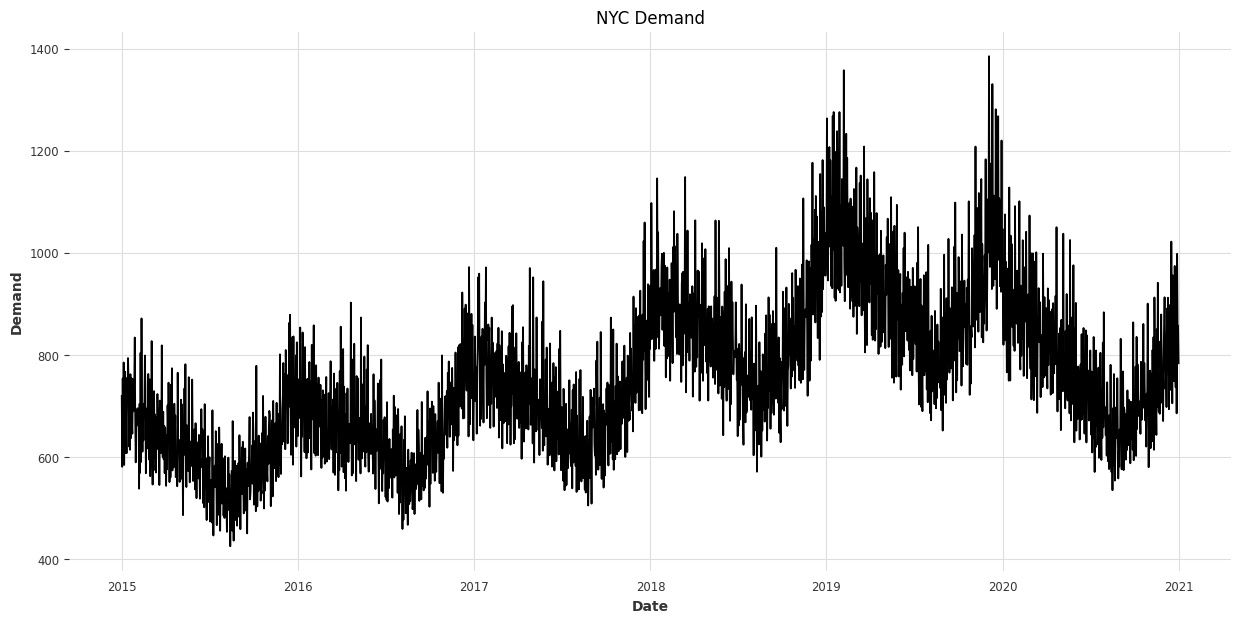

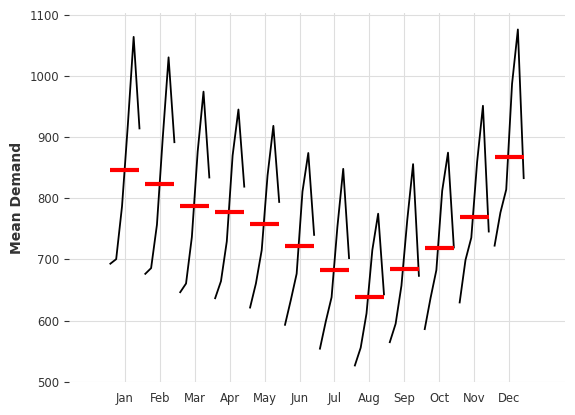

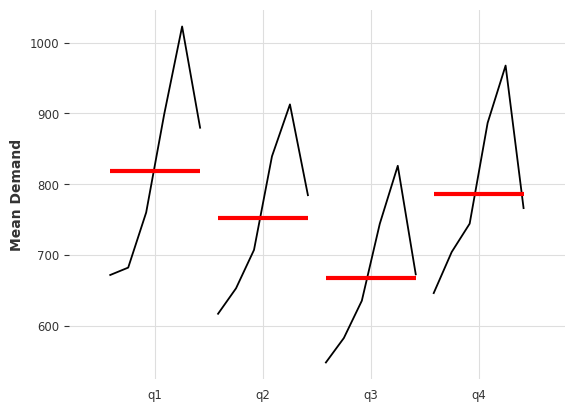

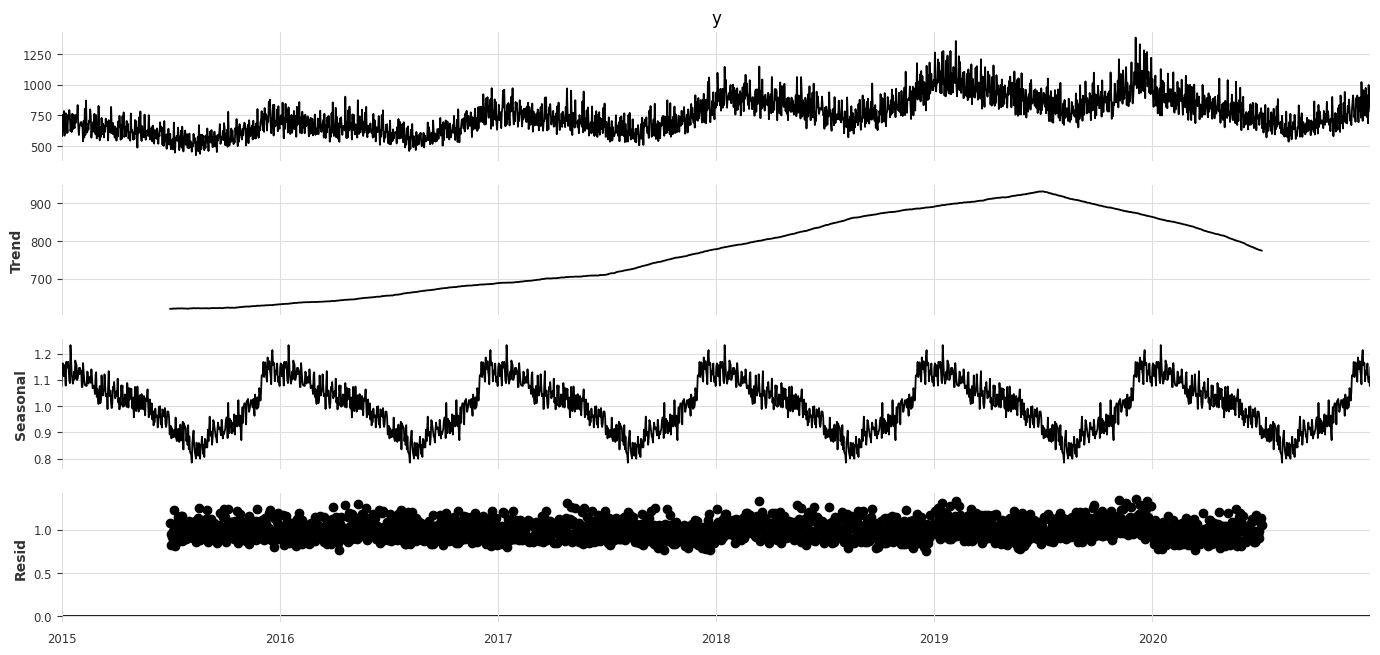

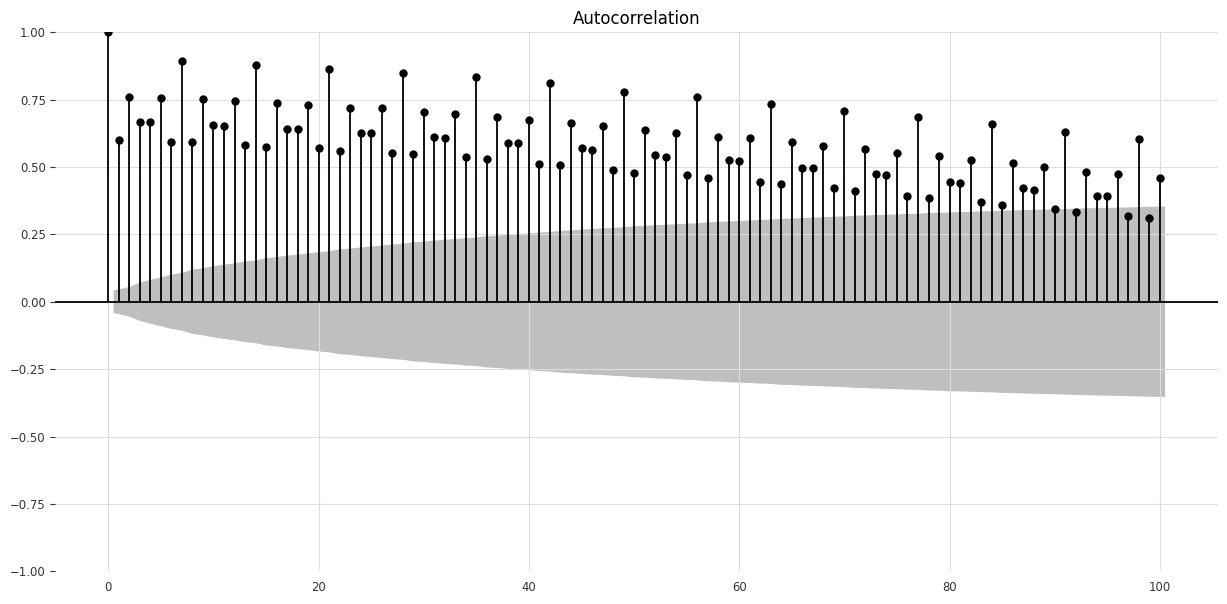

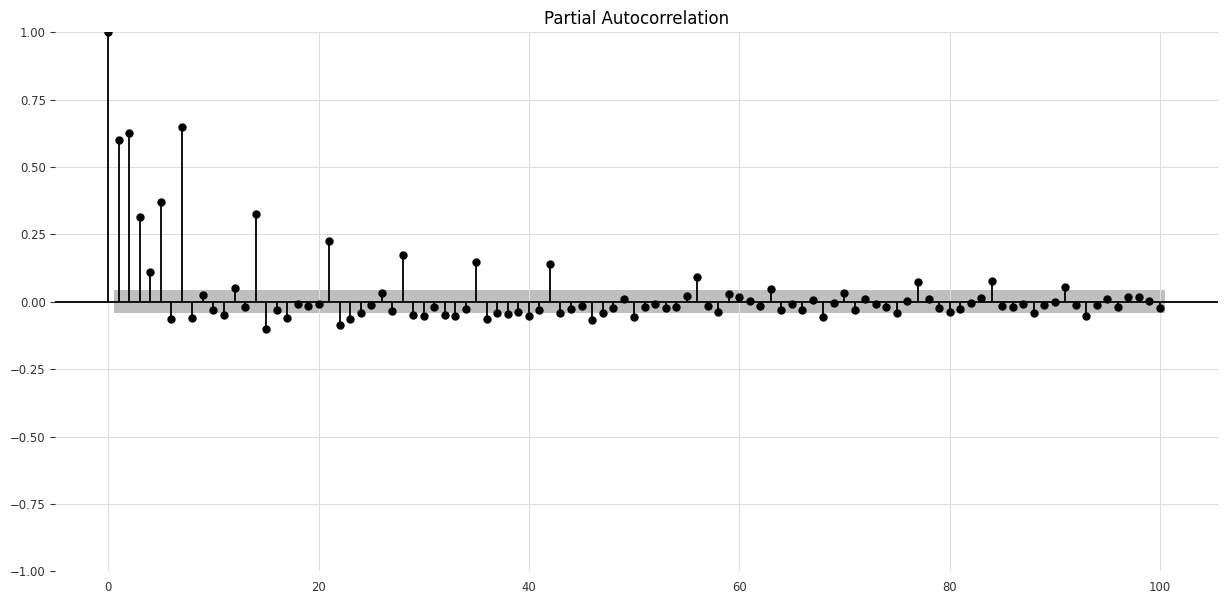

In [4]:
plt.figure(figsize=(15, 7))
plt.plot(df['y'])
plt.title('NYC Demand')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.show()

month_plot(df['y'].resample('ME').mean(), ylabel='Mean Demand')
plt.show()

quarter_plot(df['y'].resample('QE').mean(), ylabel='Mean Demand')
plt.show()

decomposition = seasonal_decompose(df['y'], model='mul', period=365)
fig = decomposition.plot()
fig.set_size_inches(15, 7)
plt.show()

fig, ax = plt.subplots(figsize=(15, 7))
plot_acf(df['y'], ax=ax, lags=100)
plt.show()

fig, ax = plt.subplots(figsize=(15, 7))
plot_pacf(df['y'], ax=ax, lags=100)
plt.show()

## Preprocessing Data

In [5]:
series = TimeSeries.from_series(df['y'])
covariates = TimeSeries.from_dataframe(df.iloc[:,1:])

# Create datetime attribute timeseries
year_series = datetime_attribute_timeseries(series, attribute='year', one_hot=False)
month_series = datetime_attribute_timeseries(series, attribute='month', one_hot=True)
weekday_series = datetime_attribute_timeseries(series, attribute='weekday', one_hot=True)

# Scale the series
scalerForSeries = Scaler()
scalerForCovariates = Scaler()
y_transformed = scalerForSeries.fit_transform(series)

covariates = covariates.stack(year_series)
covariates_transformed = scalerForCovariates.fit_transform(covariates)
covariates_transformed = covariates_transformed.stack(month_series).stack(weekday_series)

# Convert from float64 to float32
y_transformed = y_transformed.astype(np.float32)
covariates_transformed = covariates_transformed.astype(np.float32)

## LSTM Model
https://unit8co.github.io/darts/generated_api/darts.models.forecasting.rnn_model.html

In [6]:
forecasting_horizon = 31
input_chunk_length = 46 # 31 + 15
training_length = forecasting_horizon + input_chunk_length

model = RNNModel(
    model='LSTM',
    input_chunk_length=input_chunk_length,
    n_epochs=10,
    dropout=0.1,
    training_length=training_length,
    optimizer_kwargs={'lr': 1e-3},
    random_state=1502,
    force_reset=True,
    save_checkpoints=True,
    n_rnn_layers=2,
    hidden_dim=20,
    pl_trainer_kwargs={
        'accelerator': 'gpu',
        "devices": -1
    },
)

model.fit(y_transformed, future_covariates=covariates_transformed, verbose=True)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

/Users/kin/.pyenv/versions/3.9.10/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:384: `ModelCheckpoint(monitor='val_loss')` could not find the monitored key in the returned metrics: ['train_loss', 'epoch', 'step']. HINT: Did you call `log('val_loss', value)` in the `LightningModule`?
`Trainer.fit` stopped: `max_epochs=10` reached.


RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=2, dropout=0.1, training_length=77, input_chunk_length=46, n_epochs=10, optimizer_kwargs={'lr': 0.001}, random_state=1502, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': -1})

# Cross Validation

In [ ]:
# if this fails
# try: pip install ipywidgets jupyter
cv = model.historical_forecasts(
    series=y_transformed,
    future_covariates=covariates_transformed,
    start=df.shape[0] - 180,
    forecast_horizon=forecasting_horizon,
    stride=16,
    retrain=True,
    last_points_only=False,
    verbose=True
)

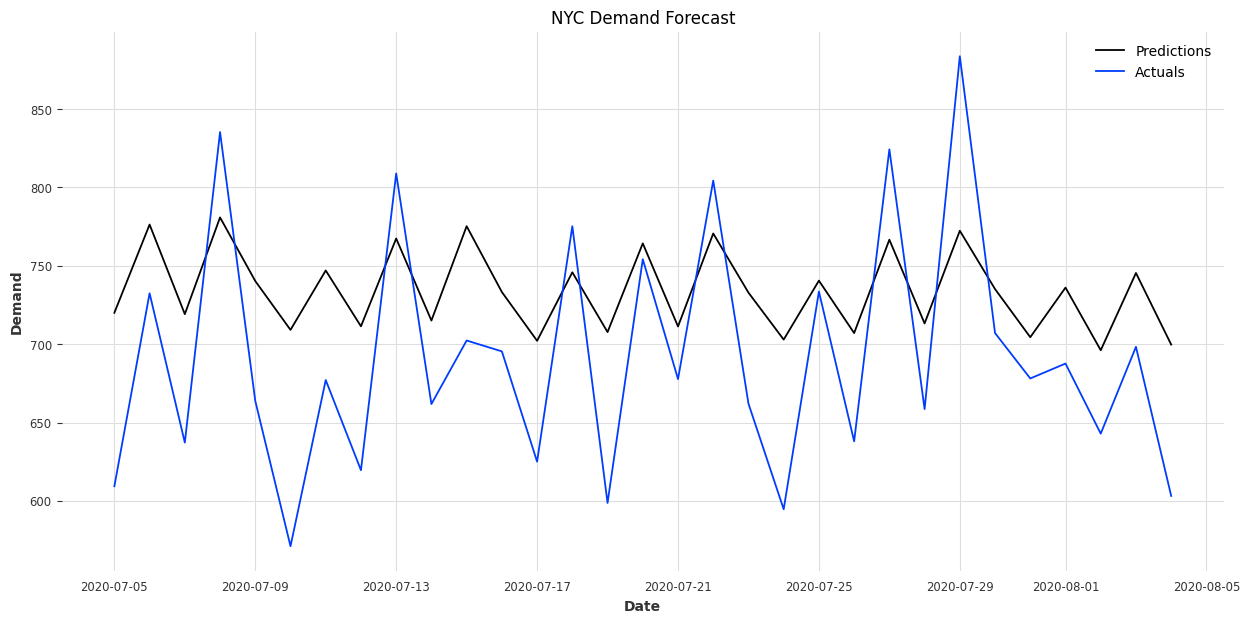

RMSE: 70.24234714669974


In [15]:
# try interpreting one of the forecasts
predictions = TimeSeries.pd_dataframe(scalerForSeries.inverse_transform(cv[0]))
actuals = df.y[predictions.index.min(): predictions.index.max(),]
plt.figure(figsize=(15, 7))
plt.plot(predictions, label='Predictions')
plt.plot(actuals, label='Actuals')
plt.title('NYC Demand Forecast')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.show()
rmse = root_mean_squared_error(actuals, predictions)
print(f'RMSE: {rmse}')

In [16]:
# get all cv's rmse
rmse_list = []
for i in range(len(cv)):
    predictions = TimeSeries.pd_dataframe(scalerForSeries.inverse_transform(cv[i]))
    actuals = df.y[predictions.index.min(): predictions.index.max(),]
    rmse = root_mean_squared_error(actuals, predictions)
    rmse_list.append(rmse)
print(f'RMSE: {np.mean(rmse_list)}')

RMSE: 77.26604268202023


## Fine Tunning

In [17]:
# Define the parameter grid for tuning
param_grid = {'n_rnn_layers': [1, 2],                 # Number of RNN layers to test
              'hidden_dim': [10, 20],                 # Number of hidden units in the LSTM layers
              'dropout': [0.1, 0.2],                  # Dropout rates to test
              'n_epochs': [5, 10],                    # Number of epochs for training
              'lr': [0.003],                          # Learning rates to test
              'training_length': [77],                # Training length to use
              'input_chunk_length': [46]}             # Length of input chunks to use

# Generate all combinations of the parameters
grid = ParameterGrid(param_grid)

# Get the total number of parameter combinations
len(list(grid))

16

In [ ]:
def train_model(params):
    """
    Train the model with the given parameters and return the RMSE.
    """
    # Unpack the parameters
    n_rnn_layers = params['n_rnn_layers']
    hidden_dim = params['hidden_dim']
    dropout = params['dropout']
    n_epochs = params['n_epochs']
    lr = params['lr']
    training_length = params['training_length']
    input_chunk_length = params['input_chunk_length']

    # Create and train the model
    model = RNNModel(
        model='LSTM',
        input_chunk_length=input_chunk_length,
        n_epochs=n_epochs,
        dropout=dropout,
        training_length=training_length,
        optimizer_kwargs={'lr': lr},
        random_state=1502,
        force_reset=True,
        save_checkpoints=True,
        n_rnn_layers=n_rnn_layers,
        hidden_dim=hidden_dim,
        pl_trainer_kwargs={
            'accelerator': 'gpu',
            "devices": -1
        },
    )

    model.fit(y_transformed, future_covariates=covariates_transformed, verbose=False)

    # Perform cross-validation
    cv = model.historical_forecasts(
        series=y_transformed,
        future_covariates=covariates_transformed,
        start=df.shape[0] - 180,
        forecast_horizon=forecasting_horizon,
        stride=16,
        retrain=True,
        last_points_only=False,
        verbose=False
    )

    # Calculate RMSE for each forecast
    rmse_list = []
    for i in range(len(cv)):
        predictions = TimeSeries.pd_dataframe(scalerForSeries.inverse_transform(cv[i]))
        actuals = df.y[predictions.index.min(): predictions.index.max(),]
        rmse = root_mean_squared_error(actuals, predictions)
        rmse_list.append(rmse)

    return np.mean(rmse_list)

best_rmse = float('inf')
best_params = None

# Iterate through all parameter combinations
for params in grid:
    print(f"Testing parameters: {params}")
    rmse = train_model(params)
    print(f"RMSE: {rmse}")

    # Update best parameters if current RMSE is lower
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

In [19]:
print(f'best parameters: {best_params}(rmse: {best_rmse})')

best parameters: {'dropout': 0.2, 'hidden_dim': 20, 'input_chunk_length': 46, 'lr': 0.003, 'n_epochs': 10, 'n_rnn_layers': 2, 'training_length': 77}(rmse: 60.666105969593104)


## Predict

In [ ]:
df_future = pd.read_csv('./data/nyc_data_future.csv', parse_dates=True, index_col='Date')
df_future = df_future.asfreq('D')
df_future = df_future.rename(columns={'Demand':'y'})
X_train = df.iloc[:,1:]
X_future = df_future.iloc[:,1:]
X = pd.concat([X_train, X_future])

series = TimeSeries.from_series(df['y'])
covariates = TimeSeries.from_dataframe(X)
year_series = datetime_attribute_timeseries(
    pd.date_range(start=series.start_time(), freq=series.freq_str, periods=X.shape[0]), 
    attribute='year', one_hot=False
    )
month_series = datetime_attribute_timeseries(year_series, attribute='month', one_hot=True)
weekday_series = datetime_attribute_timeseries(year_series, attribute='weekday', one_hot=True)

y_transformed = scalerForSeries.fit_transform(series)
covariates = covariates.stack(year_series)
covariates_transformed = scalerForCovariates.fit_transform(covariates)
covariates_transformed = covariates_transformed.stack(month_series).stack(weekday_series)
y_transformed = y_transformed.astype(np.float32)
covariates_transformed = covariates_transformed.astype(np.float32)

In [31]:
model = RNNModel(
    model='LSTM',
    input_chunk_length=best_params['input_chunk_length'],
    n_epochs=best_params['n_epochs'],
    dropout=best_params['dropout'],
    training_length=best_params['training_length'],
    optimizer_kwargs={'lr': best_params['lr']},
    random_state=1502,
    force_reset=True,
    save_checkpoints=True,
    n_rnn_layers=best_params['n_rnn_layers'],
    hidden_dim=best_params['hidden_dim'],
    pl_trainer_kwargs={
        'accelerator': 'gpu',
        "devices": -1
    },
)

model.fit(y_transformed, future_covariates=covariates_transformed, verbose=True)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params | Mode 
-------------------------------------------------------------
0 | criterion       | MSELoss          | 0      | train
1 | train_criterion | MSELoss          | 0      | train
2 | val_criterion   | MSELoss          | 0      | train
3 | train_metrics   | MetricCollection | 0      | train
4 | val_metrics     | MetricCollection | 0      | train
5 | rnn             | LSTM             | 7.2 K  | train
6 | V               | Linear           | 21     | train
-------------------------------------------------------------
7.2 K     Trainable params
0         Non-trainable params
7.2 K     Total params
0.029     Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


RNNModel(model=LSTM, hidden_dim=20, n_rnn_layers=2, dropout=0.2, training_length=77, input_chunk_length=46, n_epochs=10, optimizer_kwargs={'lr': 0.003}, random_state=1502, force_reset=True, save_checkpoints=True, pl_trainer_kwargs={'accelerator': 'gpu', 'devices': -1})

In [ ]:


cv = model.historical_forecasts(
        series=y_transformed,
        future_covariates=covariates_transformed,
        start=df.shape[0] - 180,
        forecast_horizon=forecasting_horizon,
        stride=16,
        retrain=True,
        last_points_only=False,
        verbose=False
    )



In [38]:
rmse_list = []
for i in range(len(cv)):
    predictions = TimeSeries.pd_dataframe(scalerForSeries.inverse_transform(cv[i]))
    actuals = df.y[predictions.index.min(): predictions.index.max(),]
    print(f'start: {predictions.index.min()}, end: {predictions.index.max()}')
    rmse = root_mean_squared_error(actuals, predictions)
    rmse_list.append(rmse)
print(f'RMSE: {np.mean(rmse_list)}')

start: 2020-07-05 00:00:00, end: 2020-08-04 00:00:00
start: 2020-07-21 00:00:00, end: 2020-08-20 00:00:00
start: 2020-08-06 00:00:00, end: 2020-09-05 00:00:00
start: 2020-08-22 00:00:00, end: 2020-09-21 00:00:00
start: 2020-09-07 00:00:00, end: 2020-10-07 00:00:00
start: 2020-09-23 00:00:00, end: 2020-10-23 00:00:00
start: 2020-10-09 00:00:00, end: 2020-11-08 00:00:00
start: 2020-10-25 00:00:00, end: 2020-11-24 00:00:00
start: 2020-11-10 00:00:00, end: 2020-12-10 00:00:00
start: 2020-11-26 00:00:00, end: 2020-12-26 00:00:00
RMSE: 70.35648451173027


In [40]:
predictions = model.predict(
    n = len(df_future),
    future_covariates=covariates_transformed
)
predictions = TimeSeries.pd_series(scalerForSeries.inverse_transform(predictions))

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

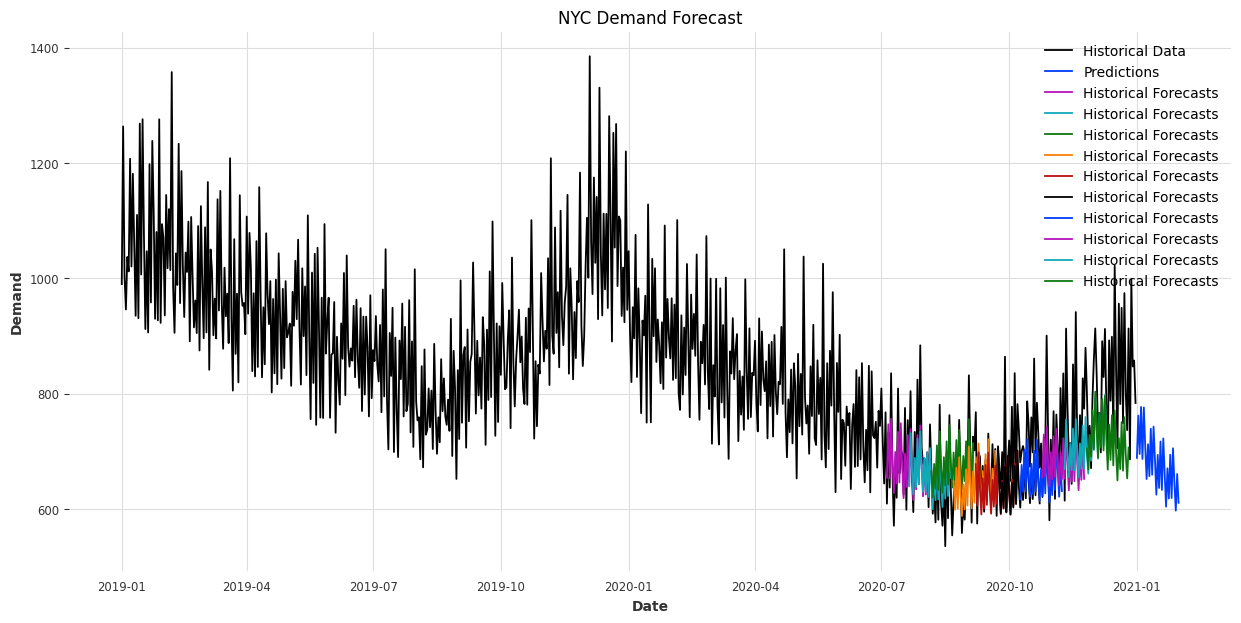

In [41]:
plt.figure(figsize=(15, 7))
plt.plot(df['2019':]['y'], label='Historical Data')
plt.plot(predictions, label='Predictions')
for i in range(len(cv)):
    his_pred = TimeSeries.pd_dataframe(scalerForSeries.inverse_transform(cv[i]))
    plt.plot(his_pred, label='Historical Forecasts')
plt.title('NYC Demand Forecast')
plt.xlabel('Date')
plt.ylabel('Demand')
plt.legend()
plt.show()